In [2]:
import scipy
import scipy.spatial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
from scipy.spatial.distance import directed_hausdorff
%load_ext Cython


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
def directed_hausdorff_brute_force(u, v):
    return max(np.amin(scipy.spatial.distance.cdist(u,v), axis = 1))

def MDA_hausdorff(u, v):
    '''3-D only transplant of the MDAnalysis implementation, adjusted
    to calculate directed Hausdorff only.'''
    N = 1
    axis = (1,)
    
    def sqnorm(v, axis=None):
        return np.sum(v*v, axis=axis)
    
    d = np.asarray([sqnorm(p - v, axis=axis) for p in u])
    return (np.amax(np.amin(d, axis=1)) / N) ** 0.5
    
    


In [4]:
from Cython.Compiler.Options import directive_defaults

directive_defaults['linetrace'] = True
directive_defaults['binding'] = True

In [5]:
%%cython -f --compile-args=-DCYTHON_TRACE=1

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
def directed_hausdorff_hardcoded_3d(np.ndarray[np.float64_t, ndim =2] ar1, np.ndarray[np.float64_t, ndim =2] ar2):

    cdef double cmax, cmin
    cdef int break_occurred
    cdef int N1 = ar1.shape[0]
    cdef int N2 = ar2.shape[0]
    cdef int data_dims = ar1.shape[1]
    cdef np.float64_t d
    cdef unsigned int i, j
    
    # shuffling the points in each array generally increases the likelihood of
    # an advantageous break in the inner search loop and never decreases the
    # performance of the algorithm
    
    np.random.shuffle(ar1)
    np.random.shuffle(ar2)
                                                                                                                                                                                                     
    cmax = 0 
    for i in range(N1):
        break_occurred = 0
        cmin = np.inf
        for j in range(N2):
            d = ((ar1[i,0] - ar2[j,0]) * (ar1[i,0] - ar2[j,0])) + \
                ((ar1[i,1] - ar2[j,1]) * (ar1[i,1] - ar2[j,1])) + \
                ((ar1[i,2] - ar2[j,2]) * (ar1[i,2] - ar2[j,2]))
            if d < cmax: # early break
                break_occurred += 1
                break
            if d < cmin:
                cmin = d
        if cmin > cmax and cmin != np.inf and break_occurred == 0:
            cmax = cmin
    return sqrt(cmax)


In [108]:
%%cython -f --compile-args=-DCYTHON_TRACE=1

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
def directed_hausdorff_memoryviews(double[:,::1] ar1, double[:,::1] ar2):

    cdef double cmax, cmin, d
    cdef int break_occurred
    cdef int N1 = ar1.shape[0]
    cdef int N2 = ar2.shape[0]
    cdef int data_dims = ar1.shape[1]
    cdef unsigned int i, j, k
    
    # shuffling the points in each array generally increases the likelihood of
    # an advantageous break in the inner search loop and never decreases the
    # performance of the algorithm
    
    np.random.shuffle(np.asarray(ar1))
    np.random.shuffle(np.asarray(ar2))
                                                                                                                                                                                                     
    cmax = 0 
    for i in range(N1):
        break_occurred = 0
        cmin = np.inf
        for j in range(N2):
            d = 0
            for k in range(data_dims):
                d += ((ar1[i,k] - ar2[j,k]) * (ar1[i,k] - ar2[j,k])) 
            if d < cmax: # early break
                break_occurred += 1
                break
            if d < cmin:
                cmin = d
        if cmin > cmax and cmin != np.inf and break_occurred == 0:
            cmax = cmin
    return sqrt(cmax)


In [120]:
%%cython -f --compile-args=-DCYTHON_TRACE=1

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False) 
def directed_hausdorff_memoryviews_no_wrap(double[:,::1] ar1, double[:,::1] ar2):

    cdef double cmax, cmin, d
    cdef int break_occurred
    cdef int N1 = ar1.shape[0]
    cdef int N2 = ar2.shape[0]
    cdef int data_dims = ar1.shape[1]
    cdef unsigned int i, j, k
    
    # shuffling the points in each array generally increases the likelihood of
    # an advantageous break in the inner search loop and never decreases the
    # performance of the algorithm
    
    np.random.shuffle(np.asarray(ar1))
    np.random.shuffle(np.asarray(ar2))
                                                                                                                                                                                                     
    cmax = 0 
    for i in range(N1):
        break_occurred = 0
        cmin = np.inf
        for j in range(N2):
            d = 0
            for k in range(data_dims):
                d += ((ar1[i,k] - ar2[j,k]) * (ar1[i,k] - ar2[j,k])) 
            if d < cmax: # early break
                break_occurred += 1
                break
            if d < cmin:
                cmin = d
        if cmin > cmax and cmin != np.inf and break_occurred == 0:
            cmax = cmin
    return sqrt(cmax)


In [125]:
%%cython -f --compile-args=-DCYTHON_TRACE=1

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt
from scipy.spatial import ckdtree

@cython.boundscheck(False)
def directed_hausdorff_memoryviews_ckdtree(double[:,::1] ar1, double[:,::1] ar2):

    cdef double cmax, cmin, d
    cdef int break_occurred
    cdef int N1 = ar1.shape[0]
    cdef int N2 = ar2.shape[0]
    cdef int data_dims = ar1.shape[1]
    cdef unsigned int i, j, k
    
    # shuffling the points in each array generally increases the likelihood of
    # an advantageous break in the inner search loop and never decreases the
    # performance of the algorithm
    
    np.random.shuffle(np.asarray(ar1))
    np.random.shuffle(np.asarray(ar2))
    
    tree = ckdtree(ar2)
    
    cmax = 0 
    for i in range(N1):
        break_occurred = 0
        cmin = np.inf
        d = tree.query(ar1[i])
        if d < cmax: # early break
            break_occurred += 1
            break
        if d < cmin:
            cmin = d
        if cmin > cmax and cmin != np.inf and break_occurred == 0:
            cmax = cmin
    return sqrt(cmax)


In [109]:
def test_approach(func, u, v, num_times = 3):
    times = []
    for i in range(num_times):
        start = time.time()
        d = func(u,v)
        end = time.time()
        times.append(end - start)
    print 'd:', d
    return np.mean(times)


In [126]:
# interleave performance tests
brute_times = []
new_algorithm_times = []
scipy_algorithm_times = []
MDA_algorithm_times = []
memoryview_algorithm_times = []
memoryview_nowrap_algorithm_times = []
ckdtree_times = []
total_points = np.linspace(400,50000,num=40)
for point_total in total_points:
    points_per_array = int(point_total / 2)
    u = np.random.random((points_per_array, 3))
    v = np.random.random((points_per_array, 3))
    
    # brute force approach bench
    #brute_force_avg_time = test_approach(directed_hausdorff_brute_force, u, v, num_times = 3)
    #brute_times.append(brute_force_avg_time)
    
    # new algorithm bench with hardcoding
    new_algorithm_avg_time = test_approach(directed_hausdorff_hardcoded_3d, u, v, num_times = 3)
    new_algorithm_times.append(new_algorithm_avg_time)
    
    # the scipy.spatial.distance implementation
    scipy_algorithm_avg_time = test_approach(directed_hausdorff, u, v, num_times = 3)
    scipy_algorithm_times.append(scipy_algorithm_avg_time)
    
    # the memoryview implementation
    memoryview_algorithm_avg_time = test_approach(directed_hausdorff_memoryviews, u, v, num_times = 3)
    memoryview_algorithm_times.append(memoryview_algorithm_avg_time)
    
    # the memoryview ckdtree implementation
    ckdtree_avg_time = test_approach(directed_hausdorff_memoryviews, u, v, num_times = 3)
    ckdtree_times.append(ckdtree_avg_time)
    
    # the memoryview nowrap implementation
    memoryview_nowrap_algorithm_avg_time = test_approach(directed_hausdorff_memoryviews_no_wrap, u, v, num_times = 3)
    memoryview_nowrap_algorithm_times.append(memoryview_nowrap_algorithm_avg_time)
    
    # the transplanted MDAnalysis implementation
    #MDA_algorithm_avg_time = test_approach(MDA_hausdorff, u, v, num_times = 3)
    #MDA_algorithm_times.append(MDA_algorithm_avg_time)

d: 0.241716506028
d: 0.241716506028
d: 0.241716506028
d: 0.241716506028
d: 0.241716506028
d: 0.152861867384
d: 0.152861867384
d: 0.152861867384
d: 0.152861867384
d: 0.152861867384
d: 0.124567216305
d: 0.124567216305
d: 0.124567216305
d: 0.124567216305
d: 0.124567216305
d: 0.131186262854
d: 0.131186262854
d: 0.131186262854
d: 0.131186262854
d: 0.131186262854
d: 0.10945325765
d: 0.10945325765
d: 0.10945325765
d: 0.10945325765
d: 0.10945325765
d: 0.0980750542322
d: 0.0980750542322
d: 0.0980750542322
d: 0.0980750542322
d: 0.0980750542322
d: 0.0953448347678
d: 0.0953448347678
d: 0.0953448347678
d: 0.0953448347678
d: 0.0953448347678
d: 0.0982443115034
d: 0.0982443115034
d: 0.0982443115034
d: 0.0982443115034
d: 0.0982443115034
d: 0.0816487583932
d: 0.0816487583932
d: 0.0816487583932
d: 0.0816487583932
d: 0.0816487583932
d: 0.0875440510764
d: 0.0875440510764
d: 0.0875440510764
d: 0.0875440510764
d: 0.0875440510764
d: 0.0848572216096
d: 0.0848572216096
d: 0.0848572216096
d: 0.0848572216096
d: 0

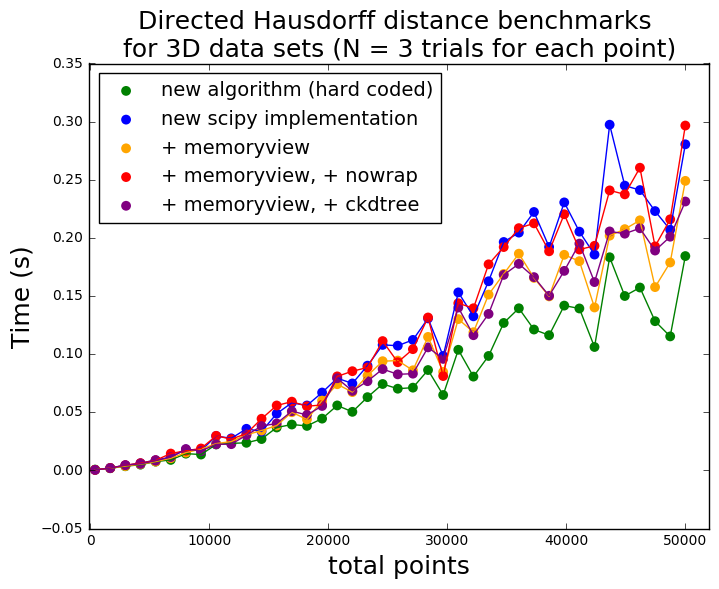

In [127]:
fig = plt.figure()
ax = fig.add_subplot('111')
ax.scatter(total_points, new_algorithm_times, color = 'green', edgecolor='none', label = 'new algorithm (hard coded)', s = 50)
ax.plot(total_points, new_algorithm_times, color = 'green')
ax.scatter(total_points, scipy_algorithm_times, color = 'blue', edgecolor='none', label = 'new scipy implementation', s = 50)
ax.plot(total_points, scipy_algorithm_times, color = 'blue')
ax.scatter(total_points, memoryview_algorithm_times, color = 'orange', edgecolor='none', label = '+ memoryview', s = 50)
ax.plot(total_points, memoryview_algorithm_times, color = 'orange')
ax.scatter(total_points, memoryview_nowrap_algorithm_times, color = 'red', edgecolor='none', label = '+ memoryview, + nowrap', s = 50)
ax.plot(total_points, memoryview_nowrap_algorithm_times, color = 'red')
ax.scatter(total_points, ckdtree_times, color = 'purple', edgecolor='none', label = '+ memoryview, + ckdtree', s = 50)
ax.plot(total_points, ckdtree_times, color = 'purple')
ax.legend(loc=2, scatterpoints=1, fontsize=14)
ax.set_ylabel('Time (s)', fontsize = 18)
ax.set_xlabel('total points', fontsize = 18)
ax.set_title('Directed Hausdorff distance benchmarks \nfor 3D data sets (N = 3 trials for each point)', fontsize = 18)
ax.set_xlim(-100,52000)
#ax.set_ylim(-1,25)
fig.set_size_inches(8,6)
fig.savefig('hausdorff_bench.png', dpi = 300)

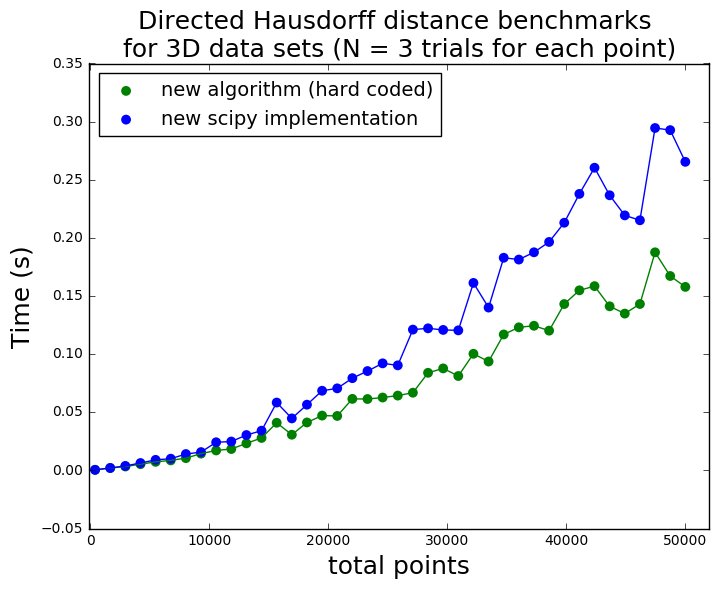

In [31]:
# high perf comparison plot
fig2 = plt.figure()
ax = fig2.add_subplot('111')

ax.scatter(total_points, new_algorithm_times, color = 'green', edgecolor='none', label = 'new algorithm (hard coded)', s = 50)
ax.plot(total_points, new_algorithm_times, color = 'green')
ax.scatter(total_points, scipy_algorithm_times, color = 'blue', edgecolor='none', label = 'new scipy implementation', s = 50)
ax.plot(total_points, scipy_algorithm_times, color = 'blue')
ax.legend(loc=2, scatterpoints=1, fontsize=14)
ax.set_ylabel('Time (s)', fontsize = 18)
ax.set_xlabel('total points', fontsize = 18)
ax.set_title('Directed Hausdorff distance benchmarks \nfor 3D data sets (N = 3 trials for each point)', fontsize = 18)
ax.set_xlim(-100,52000)
fig2.set_size_inches(8,6)
fig2.savefig('hausdorff_bench_zoom.png', dpi = 300)